In [229]:
import os

import time

import numpy as np

from scipy.spatial.distance import pdist, squareform

import networkx as nx

import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

In [230]:
import matplotlib.pyplot as plt

# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 16  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 16  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 20  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 24  # Font size of titlea

plt.rcParams['legend.fontsize'] = 16



# Covariates simulation

In [231]:
# n_cities = 10

# uniform_distr_tuple = ( tfp.distributions.Uniform(low = [0.0, 0.0], high = [10.0,  2.0]),
# 			tfp.distributions.Uniform(low = [0.0, 8.0], high = [10.0, 10.0]),
# 			tfp.distributions.Uniform(low = [0.0, 0.0], high = [ 2.0, 10.0]),
# 			tfp.distributions.Uniform(low = [8.0, 0.0], high = [10.0, 10.0]))
# centroids_index     = tfp.distributions.Categorical(logits= tf.ones(4)).sample(n_cities)
# centroids = tf.stack([uniform_distr_tuple[i].sample() for i in centroids_index], axis = 0)

# mixtures_coef = tfp.distributions.Dirichlet(concentration= 5*tf.ones(n_cities)).sample()

# diag_list = [[1.0, 0.5], [1.0, 0.5], [0.5, 1.0], [0.5, 1.0]]
# distr_tuple = tuple(tfp.distributions.MultivariateNormalDiag(loc = centroids[i,:], scale_diag = diag_list[centroids_index[i]]) for i in range(n_cities)) 

In [232]:
# N = 50000

# individuals_per_city = tfp.distributions.Multinomial(total_count = N, probs = mixtures_coef).sample()
# location_sample = tf.concat([distr_tuple[i].sample(individuals_per_city[i]) for i in range(n_cities)], axis = 0)

# covariates_sample = tfp.distributions.Normal(loc = 0.0, scale = 1.0).sample((N, 1))

# plt.scatter(location_sample[:,0], location_sample[:,1])

In [233]:
# city_index = tf.expand_dims(tf.concat([float(i)*tf.ones(int(individuals_per_city[i])) for i in range(n_cities)], axis = 0), axis = -1)

In [234]:
# np.save("Data/SpatialInference/Input/locations.npy", location_sample)
# np.save("Data/SpatialInference/Input/covariates.npy", covariates_sample)
# np.save("Data/SpatialInference/Input/city_index.npy", city_index)

# index = np.random.choice(range(0, covariates_sample.shape[0]), covariates_sample.shape[0])
# np.save("Data/SpatialInference/Input/reshuffle.npy", index)

In [235]:
# np.save("Data/SpatialInference/Input/centroids.npy", centroids)

In [236]:
N_pop = 1000

# Spatial SIR

In [237]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
os.chdir("../")

In [238]:
index             = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/reshuffle.npy")[:N_pop], dtype = tf.int32)
location_sample   = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/locations.npy"), dtype = tf.float32)
covariates_sample = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/covariates.npy"), dtype = tf.float32)

covariates = tf.gather(covariates_sample, index, axis = 0)
locations  = tf.gather(location_sample, index, axis = 0)
observed_index = tf.concat((tf.ones(500), tf.zeros(500)), axis = 0)

In [239]:
parameters = {"prior_infection":tf.convert_to_tensor([1-0.5, 0.5, 0.0], dtype = tf.float32),
	      "log_beta":tf.math.log(
		      tf.convert_to_tensor([3.0], dtype = tf.float32)),
	      "b_S":tf.convert_to_tensor([+0.5], dtype = tf.float32),
              "b_I":tf.convert_to_tensor([+1.0], dtype = tf.float32),
              "log_gamma":tf.math.log(
		      tf.convert_to_tensor([0.05], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([-0.1], dtype = tf.float32),
              "log_phi":tf.math.log(
		      tf.convert_to_tensor([1.5], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
		      tf.convert_to_tensor([0.0001], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.1, 0.2, 0.5], dtype = tf.float32))}

SIR = spatial_SIR(locations, covariates, observed_index)


In [240]:
T    = 100

tf.random.set_seed((123))
np.random.seed((123))

start = time.time()
X, Y = simulator(SIR, parameters, T, seed_sim = 123)
print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

# fig, ax = plt.subplots(2, 4, figsize = (10, 5), sharex=True, sharey=True)

# for i in range(2):
# 	for j in range(4):

# 		t = 5*(i*4+j)+1

# 		loc_suscept = tf.gather(locations, tf.where(X[t,:,0]==1)[:,0], axis = 0)
# 		loc_infecte = tf.gather(locations, tf.where(X[t,:,1]==1)[:,0], axis = 0)
# 		loc_removed = tf.gather(locations, tf.where(X[t,:,2]==1)[:,0], axis = 0)

# 		ax[i, j].set_title("Time "+str(t))
# 		ax[i, j].scatter(loc_suscept[:,0], loc_suscept[:,1], color = "#2c7bb6", s= 5, label = "S", edgecolors='black', linewidths=0.1)
# 		ax[i, j].scatter(loc_infecte[:,0], loc_infecte[:,1], color = "#d7191c", s= 5, label = "I", edgecolors='black', linewidths=0.1)
# 		ax[i, j].scatter(loc_removed[:,0], loc_removed[:,1], color = "black", s= 5, label = "R", edgecolors='black', linewidths=0.1)

# 		ax[i, j].legend()

1.8263473510742188


In [241]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
os.chdir("../")

In [242]:
n_gradient_steps = 500

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.5, 0.5, 0.0], dtype = tf.float32),
	      "log_beta":tf.math.log(
		      tf.convert_to_tensor([1.0], dtype = tf.float32)),
	      "b_S":tf.convert_to_tensor([+0.0], dtype = tf.float32),
              "b_I":tf.convert_to_tensor([+0.0], dtype = tf.float32),
              "log_gamma":tf.math.log(
		      tf.convert_to_tensor([0.2], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([0.0], dtype = tf.float32),
              "log_phi":tf.math.log(
		      tf.convert_to_tensor([3], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
		      tf.convert_to_tensor([0.0001], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.5, 0.5, 0.5], dtype = tf.float32))}

learning_parameters = {"log_beta":1, "b_S":1, "b_I":1, "log_gamma":1, "b_R":1, "log_phi":1, "logit_prob_testing":3} 

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

loss_tensor, parameters_tensor = CAL_inference(SIR, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps, initialization = "parameters")

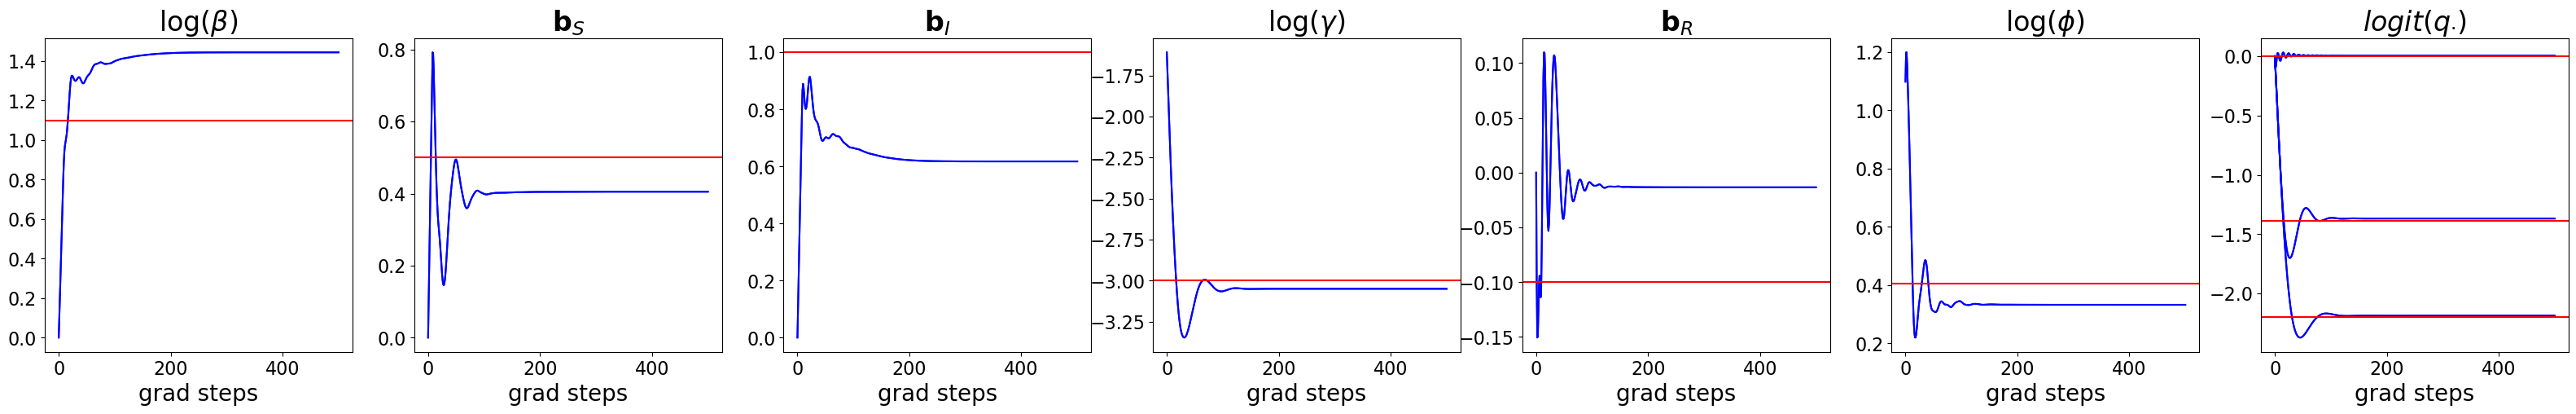

In [243]:
fig, ax = plt.subplots(1, len(learning_parameters), figsize = ((len(learning_parameters)+1)*5, 5))

ylabel_dict = { "log_beta" : "$\\log(\\beta)$", 
		"b_S" : "$\mathbf{b}_{S}$", 
		"b_I": "$\mathbf{b}_{I}$", 
		"log_phi":"$\\log(\\phi)$",
		"log_gamma": "$\\log(\\gamma)$", 
		"b_R": "$\mathbf{b}_{R}$",
		"logit_prob_testing":"$logit(q_{\cdot})$",
		}

counter = -1
for key in learning_parameters.keys():
	
	for i in range(learning_parameters[key]):
		ax[counter+1].set_title(ylabel_dict[key])
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")
		ax[counter+1].set_xlabel("grad steps")

	counter = counter +1

In [244]:
parameters_optimized = {}

for key in parameters.keys():

	if key in parameters_tensor.keys():
		parameters_optimized[key] = parameters_tensor[key][-1,...]

	else:
		parameters_optimized[key] = parameters[key]

Pi, Mu, log_likelihood_wrong = CAL(SIR, parameters_optimized, Y)

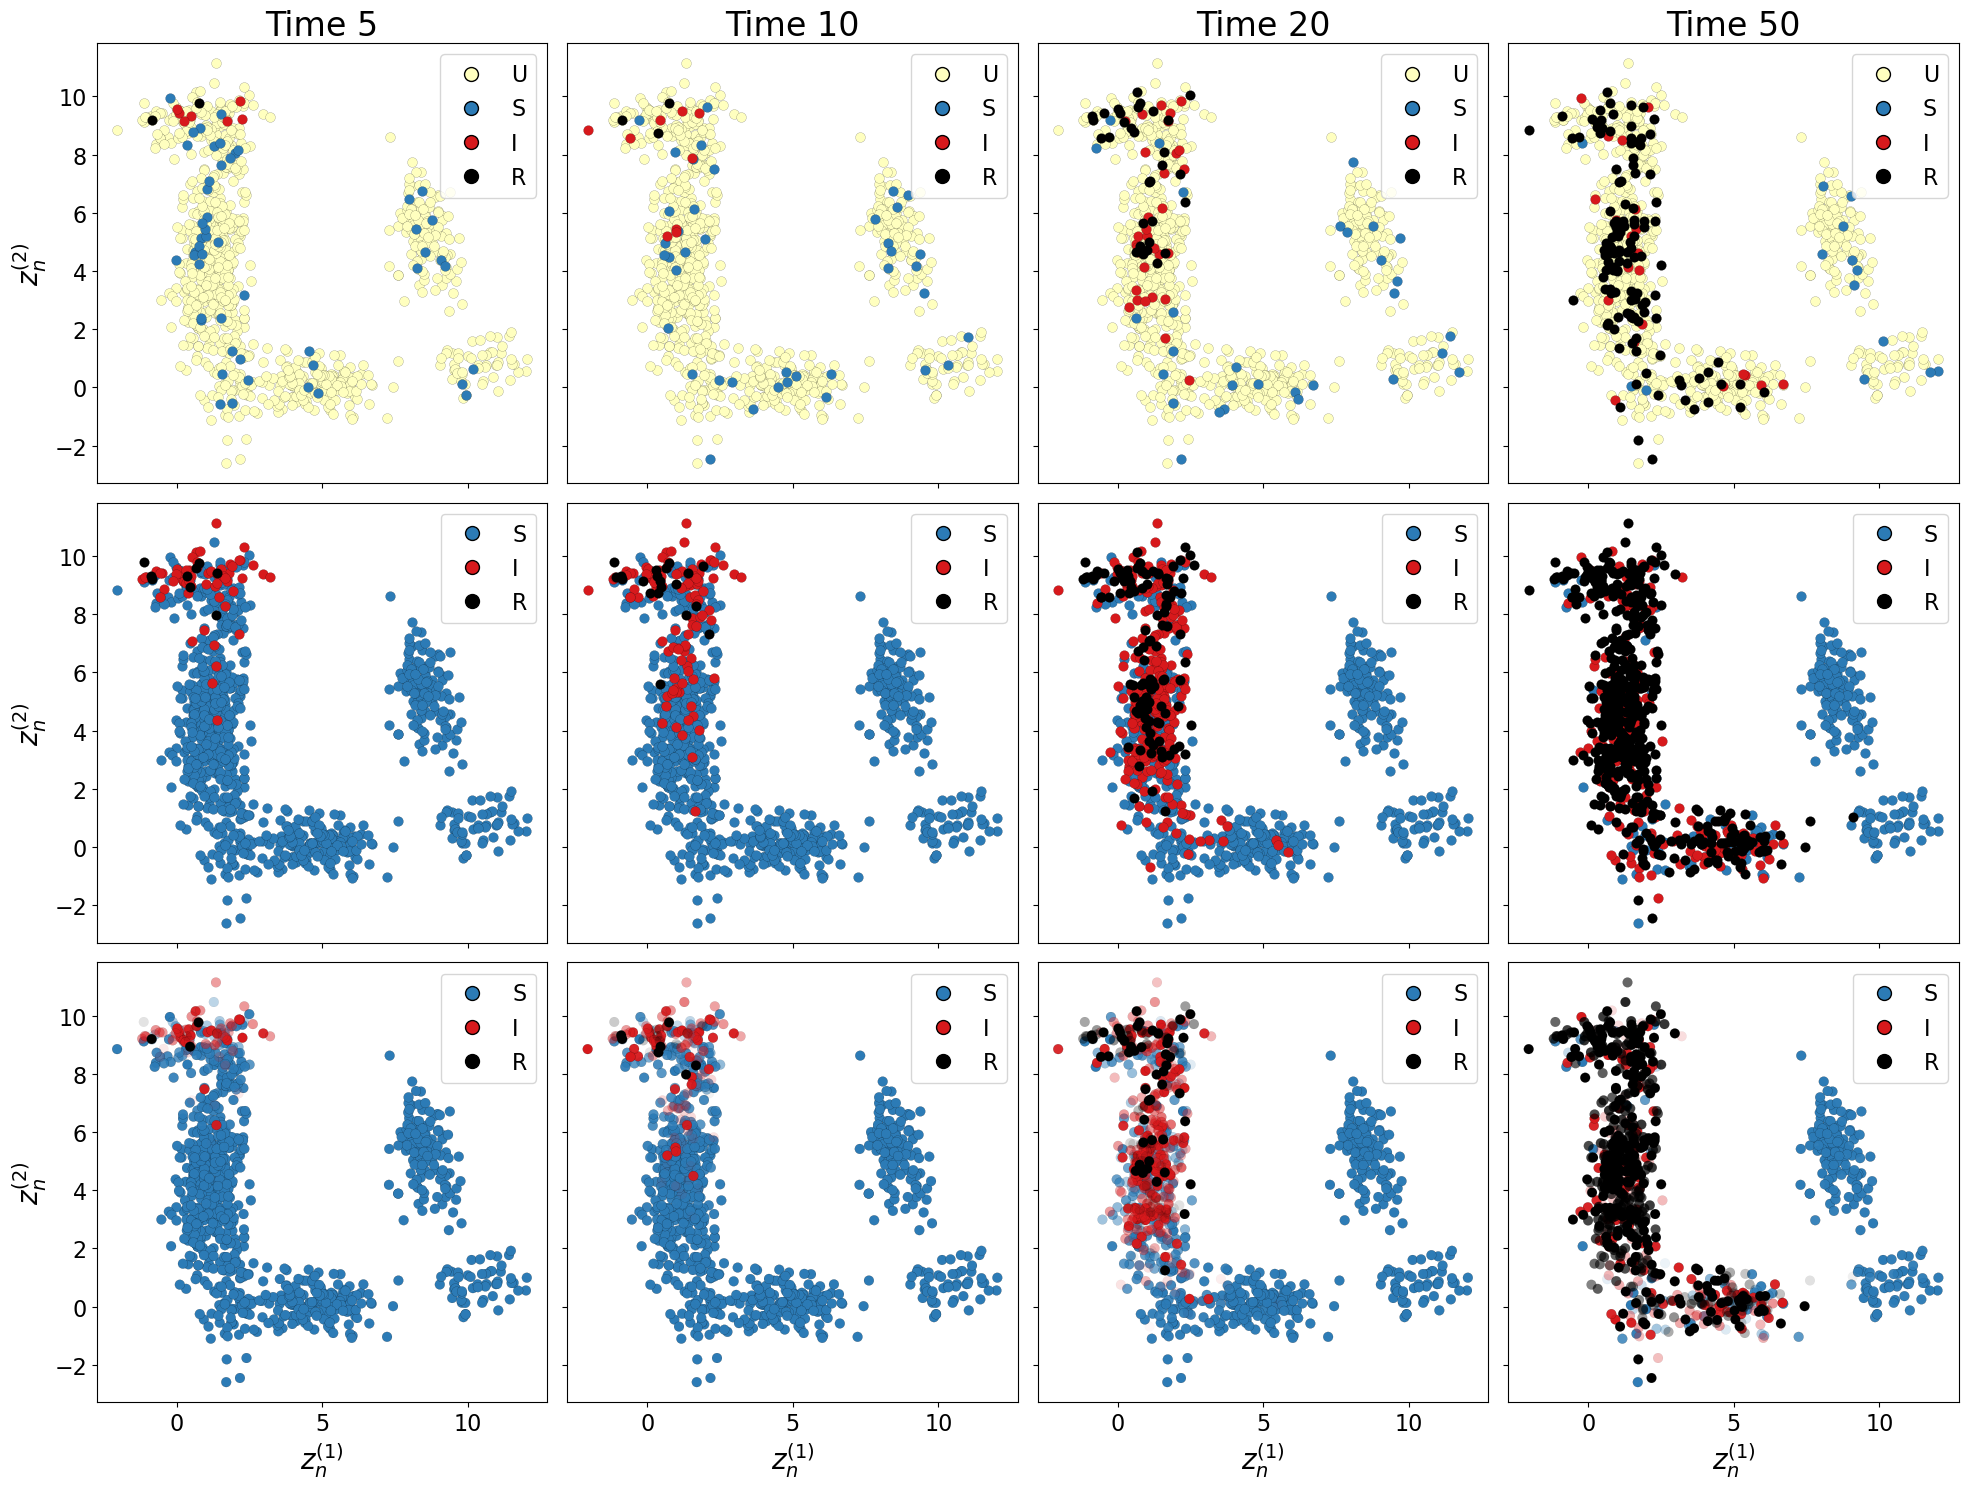

In [245]:
fig, ax = plt.subplots(3, 4, figsize = (20, 15), sharex=True, sharey=True)

time_list = [5, 10, 20, 50]

ax[0, 0].set_ylabel(r"$z_n^{(2)}$")
ax[1, 0].set_ylabel(r"$z_n^{(2)}$")
ax[2, 0].set_ylabel(r"$z_n^{(2)}$")

s_size = 50

# for visual purposes make the CAL red when prob>0.2

for j in range(4):

	t = time_list[j]
	
	ax[0, j].set_title("Time "+str(t))

	loc_y_unrepor = tf.gather(locations, tf.where(Y[t-1,:,0]==1)[:,0], axis = 0)
	loc_y_suscept = tf.gather(locations, tf.where(Y[t-1,:,1]==1)[:,0], axis = 0)
	loc_y_infecte = tf.gather(locations, tf.where(Y[t-1,:,2]==1)[:,0], axis = 0)
	loc_y_removed = tf.gather(locations, tf.where(Y[t-1,:,3]==1)[:,0], axis = 0)

	ax[0, j].scatter(loc_y_unrepor[:,0], loc_y_unrepor[:,1], color = "#ffffbf", s = s_size, edgecolors='black', linewidths=0.1 )
	ax[0, j].scatter(loc_y_suscept[:,0], loc_y_suscept[:,1], color = "#2c7bb6", s = s_size, edgecolors='black', linewidths=0.1)
	ax[0, j].scatter(loc_y_infecte[:,0], loc_y_infecte[:,1], color = "#d7191c", s = s_size, edgecolors='black', linewidths=0.1)
	ax[0, j].scatter(loc_y_removed[:,0], loc_y_removed[:,1], color = "black",   s = s_size, edgecolors='black', linewidths=0.1)
	
	legend_handles = [
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#ffffbf", markeredgecolor='black', markersize=10, label="U"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#2c7bb6", markeredgecolor='black', markersize=10, label="S"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#d7191c", markeredgecolor='black', markersize=10, label="I"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="black",   markeredgecolor='black', markersize=10, label="R")
	]

	ax[0, j].legend(handles=legend_handles, loc = "upper right")

	infected = tf.where(X[t,:,1]==1)[:,0]

	loc_suscept = tf.gather(locations, tf.where(X[t,:,0]==1)[:,0], axis = 0)
	loc_infecte = tf.gather(locations, tf.where(X[t,:,1]==1)[:,0], axis = 0)
	loc_removed = tf.gather(locations, tf.where(X[t,:,2]==1)[:,0], axis = 0)

	ax[1, j].scatter(loc_suscept[:,0], loc_suscept[:,1], color = "#2c7bb6", s = s_size, edgecolors='black', linewidths=0.1)
	ax[1, j].scatter(loc_infecte[:,0], loc_infecte[:,1], color = "#d7191c", s = s_size, edgecolors='black', linewidths=0.1)
	ax[1, j].scatter(loc_removed[:,0], loc_removed[:,1], color = "black",   s = s_size, edgecolors='black', linewidths=0.1)
	
	legend_handles = [
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#2c7bb6", markeredgecolor='black', markersize=10, label="S"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#d7191c", markeredgecolor='black', markersize=10, label="I"),	
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="black",   markeredgecolor='black', markersize=10, label="R")
	]

	ax[1, j].legend(handles=legend_handles)

	alpha_suscept = tf.gather(Pi[t,:,0], tf.where(X[t,:,0]==1)[:,0], axis = 0)
	alpha_infecte = tf.gather(Pi[t,:,1], tf.where(X[t,:,1]==1)[:,0], axis = 0)
	alpha_removed = tf.gather(Pi[t,:,2], tf.where(X[t,:,2]==1)[:,0], axis = 0)

	# alpha_suscept = 3*tf.gather(Pi[t,:,0], tf.where(X[t,:,0]==1)[:,0], axis = 0)
	# alpha_infecte = 3*tf.gather(Pi[t,:,1], tf.where(X[t,:,1]==1)[:,0], axis = 0)
	# alpha_removed = 3*tf.gather(Pi[t,:,2], tf.where(X[t,:,2]==1)[:,0], axis = 0)

	# alpha_suscept = tf.reduce_min(tf.stack((alpha_suscept, tf.ones(tf.shape(alpha_suscept))), axis  = -1), axis = -1)
	# alpha_infecte = tf.reduce_min(tf.stack((alpha_infecte, tf.ones(tf.shape(alpha_infecte))), axis  = -1), axis = -1)
	# alpha_removed = tf.reduce_min(tf.stack((alpha_removed, tf.ones(tf.shape(alpha_removed))), axis  = -1), axis = -1)
	
	ax[2, j].scatter(loc_suscept[:,0], loc_suscept[:,1], color = "#2c7bb6", alpha = alpha_suscept, s = s_size, edgecolors='black', linewidths=0.1)
	ax[2, j].scatter(loc_infecte[:,0], loc_infecte[:,1], color = "#d7191c", alpha = alpha_infecte, s = s_size, edgecolors='black', linewidths=0.1)
	ax[2, j].scatter(loc_removed[:,0], loc_removed[:,1], color = "black",   alpha = alpha_removed, s = s_size, edgecolors='black', linewidths=0.1)

	# filter_class   = tf.one_hot(tf.math.argmax(Pi, axis = -1), 3)
	# filter_suscept = tf.gather(locations, tf.where(filter_class[t,:,0]==1)[:,0], axis = 0)
	# filter_infecte = tf.gather(locations, tf.where(filter_class[t,:,1]==1)[:,0], axis = 0)
	# filter_removed = tf.gather(locations, tf.where(filter_class[t,:,2]==1)[:,0], axis = 0)
	
	# ax[2, j].scatter(filter_suscept[:,0], filter_suscept[:,1], color = "#2c7bb6", s = s_size, edgecolors='black', linewidths=0.1)
	# ax[2, j].scatter(filter_infecte[:,0], filter_infecte[:,1], color = "#d7191c", s = s_size, edgecolors='black', linewidths=0.1)
	# ax[2, j].scatter(filter_removed[:,0], filter_removed[:,1], color = "black",   s = s_size, edgecolors='black', linewidths=0.1)

	ax[2, j].set_xlabel(r"$z_n^{(1)}$")

	legend_handles = [
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#2c7bb6", markeredgecolor='black', markersize=10, label="S"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#d7191c", markeredgecolor='black', markersize=10, label="I"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="black", markeredgecolor='black', markersize=10, label="R")
	]

	ax[2, j].legend(handles=legend_handles)

plt.tight_layout()
plt.savefig('Figures/spatial_filter.png', format='png', dpi=100, bbox_inches='tight')

In [305]:
def dummy_classififer(X, Y, prob):

	if prob == "random":
		X_propagate_pred = np.zeros(tf.shape(X))

		current_state = (np.ones(X_propagate_pred[0,...].shape)/3)
		X_propagate_pred[0,...] = current_state
		for t in range(1, T+1):

			X_propagate_pred[t,...] = current_state

	else:
		X_propagate_pred = np.zeros(tf.shape(X))

		current_state = (np.ones(X_propagate_pred[0,...].shape)/3)
		X_propagate_pred[0,...] = current_state
		for t in range(1, T+1):

			observed_individuals = tf.expand_dims(tf.cast(Y[t-1,:,0]==0, dtype = tf.float32), axis = -1)

			normalized_Y = prob*Y[t-1,:,1:] + ((1-prob)/2)*(1-Y[t-1,:,1:])
			# normalized_Y = normalized_Y/tf.reduce_sum(normalized_Y, axis = -1, keepdims=True)

			current_state = current_state*(1-observed_individuals) + normalized_Y*(observed_individuals)

			X_propagate_pred[t,...] = current_state

	return X_propagate_pred


In [306]:
# X_propagate_pred = np.zeros(tf.shape(X))

# X_propagate_pred[0,...] = np.ones(X_propagate_pred[0,...].shape)/3

# for n in range(X_propagate_pred.shape[1]):
	
# 	current_state = np.ones(3)/3

# 	if (Y[0,n,1:].numpy()==0).all():
# 		X_propagate_pred[1,n,:] = np.ones(3)/3
# 	else:
# 		X_propagate_pred[1,n,:] = Y[0,n,1:]
# 		current_state = tf.where(Y[0,n,1:]==1, 0.34, 0.32)

# 		if Y[0,n,1:][-1]==1:
# 			current_state = Y[0,n,1:]

# 	for t in range(2, T+1):
# 		if (Y[t-1,n,1:].numpy()==1).any():
# 			X_propagate_pred[t,n,:] = Y[t-1,n,1:]

# 			current_state = tf.where(Y[t-1,n,1:]==1, 0.34, 0.32)

# 			if Y[t-1,n,1:][-1]==1:
# 				current_state = Y[t-1,n,1:]
# 		else:
# 			X_propagate_pred[t,n,:] = current_state

# X_propagate_pred_certain = np.zeros(tf.shape(X))

# X_propagate_pred_certain[0,...] = np.ones(X_propagate_pred_certain[0,...].shape)/3

# for n in range(X_propagate_pred_certain.shape[1]):
	
# 	current_state = np.ones(3)/3

# 	if (Y[0,n,1:].numpy()==0).all():
# 		X_propagate_pred_certain[1,n,:] = np.ones(3)/3
# 	else:
# 		X_propagate_pred_certain[1,n,:] = Y[0,n,1:]
# 		current_state = tf.where(Y[0,n,1:]==1, 0.99, 0.005)
		
# 		if Y[0,n,1:][-1]==1:
# 			current_state = Y[0,n,1:]

# 	for t in range(2, T+1):
# 		if (Y[t-1,n,1:].numpy()==1).any():
# 			X_propagate_pred_certain[t,n,:] = Y[t-1,n,1:]

# 			current_state = tf.where(Y[t-1,n,1:]==1, 0.99, 0.005)

# 			if Y[t-1,n,1:][-1]==1:
# 				current_state = Y[t-1,n,1:]
# 		else:
# 			X_propagate_pred_certain[t,n,:] = current_state

In [307]:
X_random_pred = dummy_classififer(X, Y, "random")
X_propagate_pred = dummy_classififer(X, Y, 0.34)
X_propagate_pred_certain = dummy_classififer(X, Y, 0.99)

In [308]:
print("categorical log-likelihood from rand         ", tf.reduce_mean(tf.math.log(tf.reduce_sum(X*X_random_pred, axis = -1))).numpy())
print("categorical log-likelihood from prop         ", tf.reduce_mean(tf.math.log(tf.reduce_sum(X*X_propagate_pred, axis = -1))).numpy())
print("categorical log-likelihood from prop certain ", tf.reduce_mean(tf.math.log(tf.reduce_sum(X*X_propagate_pred_certain, axis = -1))).numpy())
print("categorical log-likelihood from CAL          ", tf.reduce_mean(tf.math.log(tf.reduce_sum(X*Pi, axis = -1))).numpy())

print("accuracy from rand         ", np.sum(X*tf.one_hot(tf.math.argmax(X_random_pred, axis = -1), 3))/np.prod(X.shape[:2]))
print("accuracy from prop         ", np.sum(X*tf.one_hot(tf.math.argmax(X_propagate_pred, axis = -1), 3))/np.prod(X.shape[:2]))
print("accuracy from prop certain ", np.sum(X*tf.one_hot(tf.math.argmax(X_propagate_pred_certain, axis = -1), 3))/np.prod(X.shape[:2]))
print("accuracy from CAL          ", np.sum(X*tf.one_hot(tf.math.argmax(Pi, axis = -1), 3))/np.prod(X.shape[:2]))

categorical log-likelihood from rand          -1.0986123
categorical log-likelihood from prop          -1.0900294
categorical log-likelihood from prop certain  -0.681013
categorical log-likelihood from CAL           -0.28797188
accuracy from rand          0.3801782178217822
accuracy from prop          0.667910891089109
accuracy from prop certain  0.667910891089109
accuracy from CAL           0.8830792079207921


In [206]:
# infected_indiv = tf.where((tf.reduce_sum(Y[...,2], axis = 0)>0))

# X_unreported                        = tf.cast(tf.gather(X[-50:,...],                        infected_indiv, axis = 1), tf.float32)
# X_random_pred_unreported            = tf.cast(tf.gather(X_random_pred[-50:,...],            infected_indiv, axis = 1), tf.float32)
# X_propagate_pred_unreported         = tf.cast(tf.gather(X_propagate_pred[-50:,...],         infected_indiv, axis = 1), tf.float32)
# X_propagate_pred_certain_unreported = tf.cast(tf.gather(X_propagate_pred_certain[-50:,...], infected_indiv, axis = 1), tf.float32)
# Pi_unreported                       = tf.cast(tf.gather(Pi[-50:,...],                       infected_indiv, axis = 1), tf.float32)

# print("categorical log-likelihood from rand         ", tf.reduce_mean(tf.math.log(tf.reduce_sum(X_unreported*X_random_pred_unreported, axis = -1))).numpy())
# print("categorical log-likelihood from prop         ", tf.reduce_mean(tf.math.log(tf.reduce_sum(X_unreported*X_propagate_pred_unreported, axis = -1))).numpy())
# print("categorical log-likelihood from prop certain ", tf.reduce_mean(tf.math.log(tf.reduce_sum(X_unreported*X_propagate_pred_certain_unreported, axis = -1))).numpy())
# print("categorical log-likelihood from CAL          ", tf.reduce_mean(tf.math.log(tf.reduce_sum(X_unreported*Pi_unreported, axis = -1))).numpy())

# print("accuracy from rand         ", np.sum(X_unreported*tf.one_hot(tf.math.argmax(X_random_pred_unreported, axis = -1), 3))/np.prod(X.shape[:2]))
# print("accuracy from prop         ", np.sum(X_unreported*tf.one_hot(tf.math.argmax(X_propagate_pred_unreported, axis = -1), 3))/np.prod(X.shape[:2]))
# print("accuracy from prop certain ", np.sum(X_unreported*tf.one_hot(tf.math.argmax(X_propagate_pred_certain_unreported, axis = -1), 3))/np.prod(X.shape[:2]))
# print("accuracy from CAL          ", np.sum(X_unreported*tf.one_hot(tf.math.argmax(Pi_unreported, axis = -1), 3))/np.prod(X.shape[:2]))

# Graph SIR

In [208]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
os.chdir("../")

In [209]:
centroids  = np.load("Data/SpatialInference/Input/centroids.npy")
city_index = np.load("Data/SpatialInference/Input/city_index.npy")

index             = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/reshuffle.npy")[:N_pop], dtype = tf.int32)
location_sample   = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/locations.npy"), dtype = tf.float32)
covariates_sample = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/covariates.npy"), dtype = tf.float32)

covariates  = tf.gather(covariates_sample, index, axis = 0)
locations  = tf.gather(location_sample, index, axis = 0)
communities = tf.gather(city_index, index, axis = 0)

mean_distances = np.zeros(np.unique(communities).shape[0])
for i in range(np.unique(communities).shape[0]):
	
	geo_loc = tf.gather( locations, np.where(communities[:,0] == np.unique(communities)[i])[0], axis = 0).numpy()
	distances = pdist(geo_loc)
	mean_distances[i] = distances.mean()

mean_distances = tf.expand_dims(tf.convert_to_tensor(mean_distances, dtype = tf.float32), axis = 1)

city_covariates = tf.concat((centroids, mean_distances), axis = -1)

_, populations = np.unique(communities, return_counts=True)

In [210]:
parameters = {"prior_infection":tf.convert_to_tensor([1-0.5, 0.5, 0.0], dtype = tf.float32),
	      "log_beta":tf.math.log(
		      tf.convert_to_tensor([3.0], dtype = tf.float32)),
	      "b_S":tf.convert_to_tensor([+0.5], dtype = tf.float32),
              "b_I":tf.convert_to_tensor([+1.0], dtype = tf.float32),
              "log_gamma":tf.math.log(
		      tf.convert_to_tensor([0.05], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([-0.1], dtype = tf.float32),
              "log_phi":tf.math.log(
		      tf.convert_to_tensor([1.5], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
		      tf.convert_to_tensor([0.0001], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.1, 0.2, 0.5], dtype = tf.float32))}

SIR = sbm_SIR(city_covariates, communities, covariates, observed_index)


In [211]:
tf.random.set_seed((123))
np.random.seed((123))

start = time.time()
X, Y = simulator(SIR, parameters, T, seed_sim = 123)
print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

# fig, ax = plt.subplots(2, 4, figsize = (10, 5), sharex=True, sharey=True)

# for i in range(2):
# 	for j in range(4):

# 		t = 5*(i*4+j)

# 		sizes = populations

# 		infected_per_community = tf.einsum("...n,nc->...c", X[t,:,1], SIR.communities)

# 		ax[i, j].set_title("Time "+str(t))
# 		ax[i, j].scatter( centroids[:, 0], centroids[:, 1], color="#2c7bb6", s=2*populations,            edgecolors="black", alpha = 0.7 )
# 		ax[i, j].scatter( centroids[:, 0], centroids[:, 1], color="#d7191c"  , s=2*infected_per_community, edgecolors="black", alpha = 0.7 )

# 		ax[i, j].set_xlim((-2, 12))
# 		ax[i, j].set_ylim((-2, 12))

1.9533312320709229


In [212]:
n_gradient_steps = 500

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.5, 0.5, 0.0], dtype = tf.float32),
	      "log_beta":tf.math.log(
		      tf.convert_to_tensor([1.0], dtype = tf.float32)),
	      "b_S":tf.convert_to_tensor([+0.0], dtype = tf.float32),
              "b_I":tf.convert_to_tensor([+0.0], dtype = tf.float32),
              "log_gamma":tf.math.log(
		      tf.convert_to_tensor([0.2], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([0.0], dtype = tf.float32),
              "log_phi":tf.math.log(
		      tf.convert_to_tensor([3], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
		      tf.convert_to_tensor([0.0001], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.5, 0.5, 0.5], dtype = tf.float32))}

learning_parameters = {"log_beta":1, "b_S":1, "b_I":1, "log_gamma":1, "b_R":1, "log_phi":1, "logit_prob_testing":3} 

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

loss_tensor, parameters_tensor = CAL_inference(SIR, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps,  initialization = "parameters")

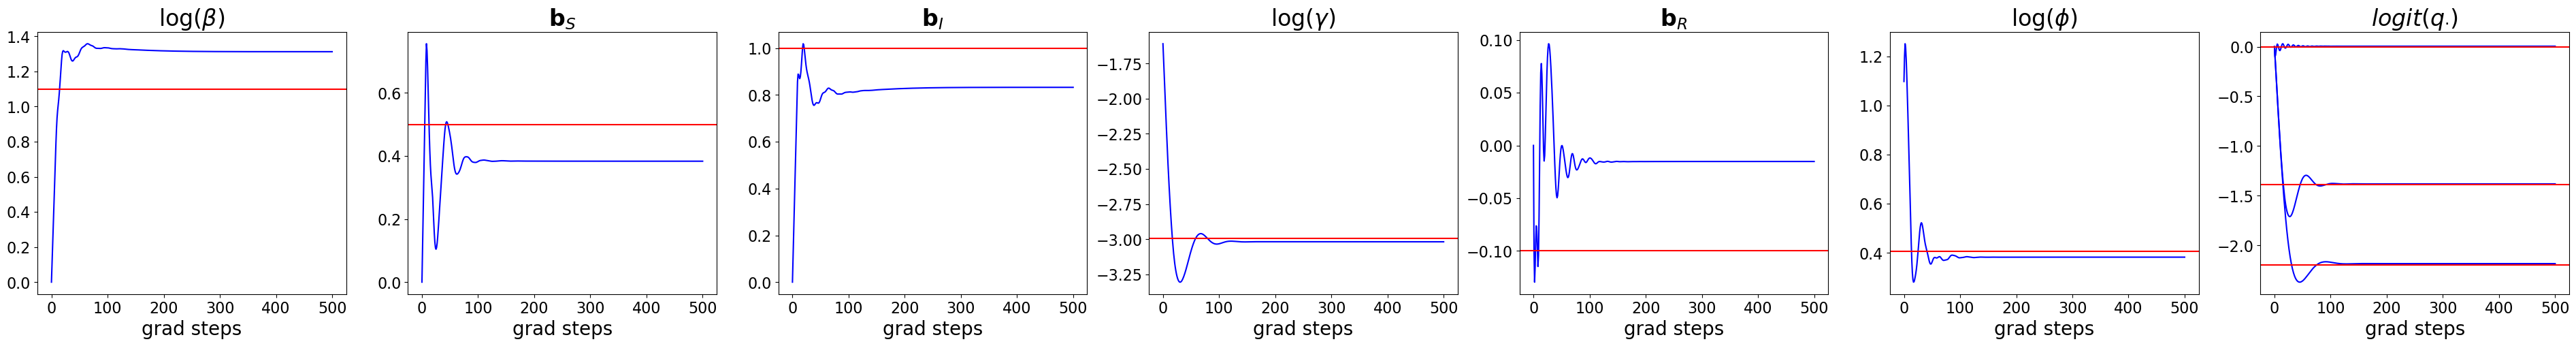

In [213]:
fig, ax = plt.subplots(1, len(learning_parameters), figsize = ((len(learning_parameters)+1)*6, 5))

ylabel_dict = { "log_beta" : "$\\log(\\beta)$", 
		"b_S" : "$\mathbf{b}_{S}$", 
		"b_I": "$\mathbf{b}_{I}$", 
		"log_gamma": "$\\log(\\gamma)$", 
		"b_R": "$\mathbf{b}_{R}$",
		"log_phi":"$\\log(\\phi)$",
		"logit_prob_testing":"$logit(q_{\cdot})$",
		}

counter = -1
for key in learning_parameters.keys():
	
	for i in range(learning_parameters[key]):
		ax[counter+1].set_title(ylabel_dict[key])
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")
		ax[counter+1].set_xlabel("grad steps")

	counter = counter +1

In [214]:
parameters_optimized = {}

for key in parameters.keys():

	if key in parameters_tensor.keys():
		parameters_optimized[key] = parameters_tensor[key][-1,...]

	else:
		parameters_optimized[key] = parameters[key]

Pi, Mu, log_likelihood_wrong = CAL(SIR, parameters_optimized, Y)

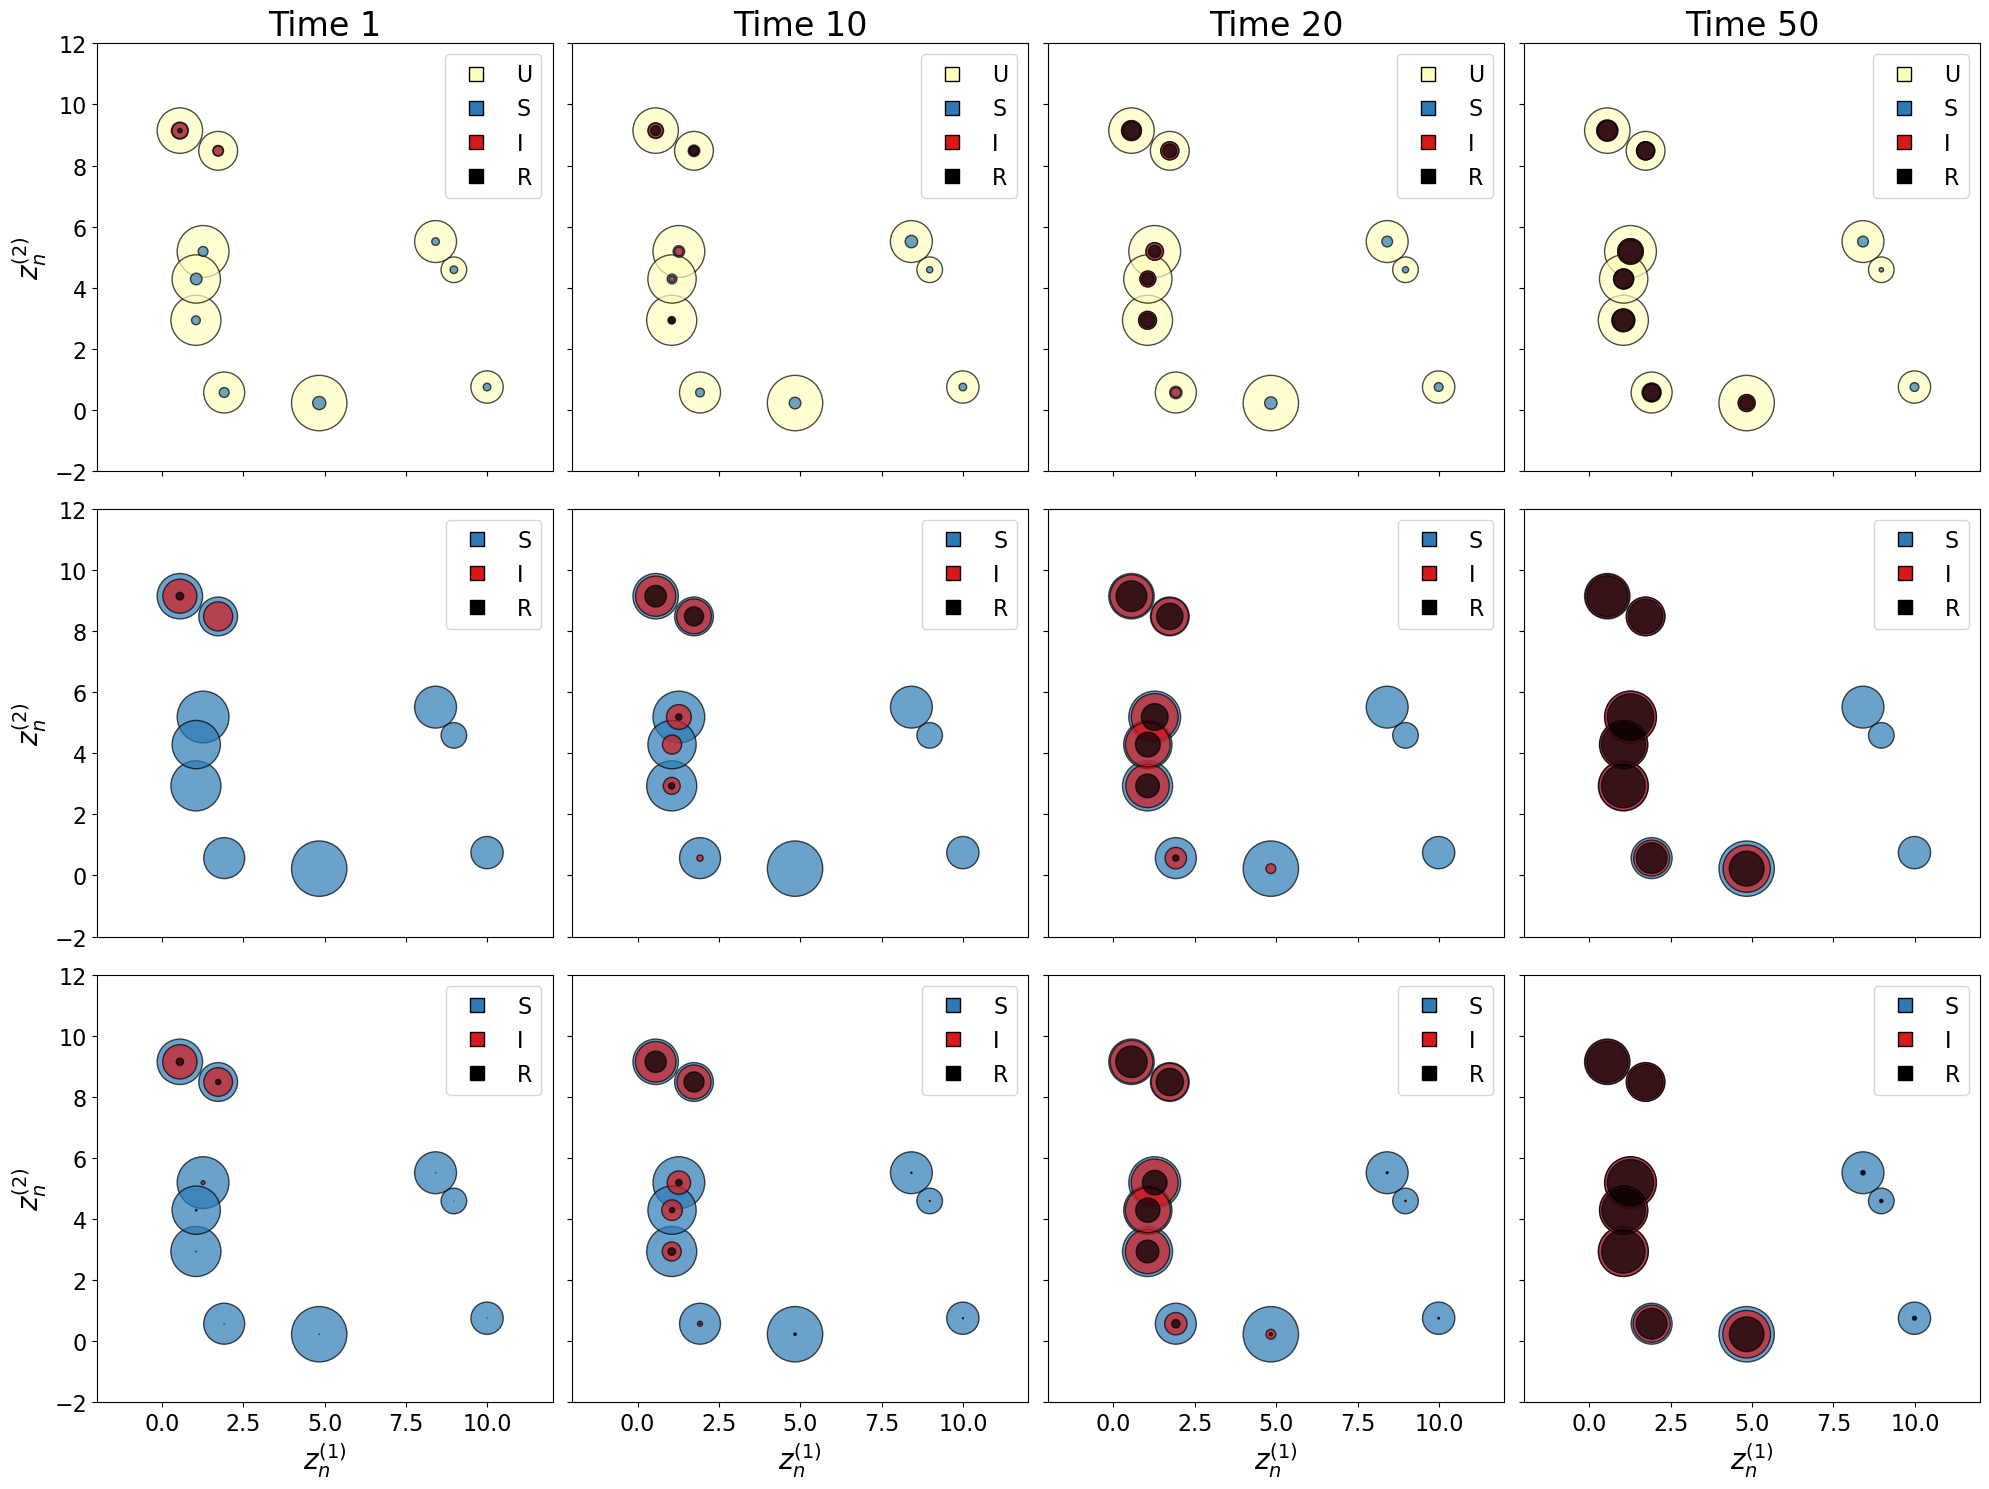

In [215]:
fig, ax = plt.subplots(3, 4, figsize = (20, 15), sharex=True, sharey=True)

time_list = [1, 10, 20, 50]

ax[0, 0].set_ylabel(r"$z_n^{(2)}$")
ax[1, 0].set_ylabel(r"$z_n^{(2)}$")
ax[2, 0].set_ylabel(r"$z_n^{(2)}$")

scaling_factor = 10

for j in range(4):

	t = time_list[j]

	observation_per_community = tf.einsum("...nm,nc->...cm", Y[t-1,...], SIR.communities)

	ax[0, j].set_title("Time "+str(t))

	ax[0, j].scatter( centroids[:, 0], centroids[:, 1], color="#ffffbf", s=scaling_factor*(populations),                         edgecolors="black", alpha = 0.7 )
	ax[0, j].scatter( centroids[:, 0], centroids[:, 1], color="#2c7bb6", s=scaling_factor*(observation_per_community[...,1] 
												+ observation_per_community[...,2] 
												+ observation_per_community[...,3]), edgecolors="black", alpha = 0.7 )
	ax[0, j].scatter( centroids[:, 0], centroids[:, 1], color="#d7191c", s=scaling_factor*(observation_per_community[...,2] 
												+ observation_per_community[...,3]), edgecolors="black", alpha = 0.7 )
	ax[0, j].scatter( centroids[:, 0], centroids[:, 1], color="black"  , s=scaling_factor*(observation_per_community[...,3]),    edgecolors="black", alpha = 0.7 )

	infected_per_community = tf.einsum("...nm,nc->...cm", X[t,...], SIR.communities)

	ax[1, j].scatter( centroids[:, 0], centroids[:, 1], color="#2c7bb6", s=scaling_factor*(infected_per_community[...,0] 
												+ infected_per_community[...,1] 
												+ infected_per_community[...,2]), edgecolors="black", alpha = 0.7 )
	ax[1, j].scatter( centroids[:, 0], centroids[:, 1], color="#d7191c", s=scaling_factor*(infected_per_community[...,1] 
												+ infected_per_community[...,2]), edgecolors="black", alpha = 0.7 )
	ax[1, j].scatter( centroids[:, 0], centroids[:, 1], color="black"  , s=scaling_factor*(infected_per_community[...,2]),    edgecolors="black", alpha = 0.7 )

	filter_per_community = tf.einsum("...nm,nc->...cm", Pi[t,...], SIR.communities)

	ax[2, j].scatter( centroids[:, 0], centroids[:, 1], color="#2c7bb6", s=scaling_factor*(filter_per_community[...,0] 
												+ filter_per_community[...,1] 
												+ filter_per_community[...,2]), edgecolors="black", alpha = 0.7 )
	ax[2, j].scatter( centroids[:, 0], centroids[:, 1], color="#d7191c", s=scaling_factor*(filter_per_community[...,1] 
												+ filter_per_community[...,2]), edgecolors="black", alpha = 0.7 )
	ax[2, j].scatter( centroids[:, 0], centroids[:, 1], color="black"  , s=scaling_factor*(filter_per_community[...,2]),    edgecolors="black", alpha = 0.7 )
	

	ax[2, j].set_xlabel(r"$z_n^{(1)}$")

	ax[0, j].set_xlim((-2, 12))
	ax[0, j].set_ylim((-2, 12))

	# Adding a legend with just the colors
	legend_colors = [
	("#ffffbf", "U"), 
	("#2c7bb6", "S"),  
	("#d7191c", "I"),  
	("black",   "R")
	]

	# Create legend handles
	handles = [
	plt.Line2D([0], [0], marker='s', color=color, markersize=10, markeredgecolor='black', linestyle='None', label=label)
	for color, label in legend_colors
	]

	# Add the legend
	ax[0, j].legend(handles=handles, loc='upper right')
	
	ax[1, j].set_xlim((-2, 12))
	ax[1, j].set_ylim((-2, 12))

	# Adding a legend with just the colors
	legend_colors = [
	("#2c7bb6", "S"),  
	("#d7191c", "I"),  
	("black",   "R")
	]

	# Create legend handles
	handles = [
	plt.Line2D([0], [0], marker='s', color=color, markersize=10, markeredgecolor='black', linestyle='None', label=label)
	for color, label in legend_colors
	]

	# Add the legend
	ax[1, j].legend(handles=handles, loc='upper right')
	
	ax[2, j].set_xlim((-2, 12))
	ax[2, j].set_ylim((-2, 12))

	# Adding a legend with just the colors
	legend_colors = [
	("#2c7bb6", "S"),  
	("#d7191c", "I"),  
	("black",   "R")
	]

	# Create legend handles
	handles = [
	plt.Line2D([0], [0], marker='s', color=color, markersize=10, markeredgecolor='black', linestyle='None', label=label)
	for color, label in legend_colors
	]

	# Add the legend
	ax[2, j].legend(handles=handles, loc='upper right')

plt.tight_layout()
plt.savefig('Figures/graph_filter.png', format='png', dpi=100, bbox_inches='tight')

# Misspecified model

In [216]:
index             = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/reshuffle.npy")[:N_pop], dtype = tf.int32)
location_sample   = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/locations.npy"), dtype = tf.float32)
covariates_sample = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/covariates.npy"), dtype = tf.float32)

covariates = tf.gather(covariates_sample, index, axis = 0)
locations  = tf.gather(location_sample, index, axis = 0)

In [217]:
parameters = {"prior_infection":tf.convert_to_tensor([1-0.5, 0.5, 0.0], dtype = tf.float32),
	      "log_beta":tf.math.log(
		      tf.convert_to_tensor([3.0], dtype = tf.float32)),
	      "b_S":tf.convert_to_tensor([+0.5], dtype = tf.float32),
              "b_I":tf.convert_to_tensor([+1.0], dtype = tf.float32),
              "log_gamma":tf.math.log(
		      tf.convert_to_tensor([0.05], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([-0.1], dtype = tf.float32),
              "log_phi":tf.math.log(
		      tf.convert_to_tensor([1.5], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
		      tf.convert_to_tensor([0.0001], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.1, 0.2, 0.5], dtype = tf.float32))}

SIR = spatial_SIR(locations, covariates, observed_index)


In [218]:
tf.random.set_seed((123))
np.random.seed((123))

start = time.time()
X, Y = simulator(SIR, parameters, T, seed_sim = 123)
print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

1.7926719188690186


In [219]:
centroids  = np.load("Data/SpatialInference/Input/centroids.npy")
city_index = np.load("Data/SpatialInference/Input/city_index.npy")

index             = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/reshuffle.npy")[:N_pop], dtype = tf.int32)
location_sample   = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/locations.npy"), dtype = tf.float32)
covariates_sample = tf.convert_to_tensor(np.load("Data/SpatialInference/Input/covariates.npy"), dtype = tf.float32)

covariates  = tf.gather(covariates_sample, index, axis = 0)
locations  = tf.gather(location_sample, index, axis = 0)
communities = tf.gather(city_index, index, axis = 0)

mean_distances = np.zeros(np.unique(communities).shape[0])
for i in range(np.unique(communities).shape[0]):
	
	geo_loc = tf.gather( locations, np.where(communities[:,0] == np.unique(communities)[i])[0], axis = 0).numpy()
	distances = pdist(geo_loc)
	mean_distances[i] = distances.mean()

mean_distances = tf.expand_dims(tf.convert_to_tensor(mean_distances, dtype = tf.float32), axis = 1)

city_covariates = tf.concat((centroids, mean_distances), axis = -1)

_, populations = np.unique(communities, return_counts=True)

SIR_misp = sbm_SIR(city_covariates, communities, covariates, observed_index)

In [220]:
n_gradient_steps = 500

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.5, 0.5, 0.0], dtype = tf.float32),
	      "log_beta":tf.math.log(
		      tf.convert_to_tensor([1.0], dtype = tf.float32)),
	      "b_S":tf.convert_to_tensor([+0.0], dtype = tf.float32),
              "b_I":tf.convert_to_tensor([+0.0], dtype = tf.float32),
              "log_gamma":tf.math.log(
		      tf.convert_to_tensor([0.2], dtype = tf.float32)),
              "b_R":tf.convert_to_tensor([0.0], dtype = tf.float32),
              "log_phi":tf.math.log(
		      tf.convert_to_tensor([3], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
		      tf.convert_to_tensor([0.0001], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.5, 0.5, 0.5], dtype = tf.float32))}

learning_parameters = {"log_beta":1, "b_S":1, "b_I":1, "log_gamma":1, "b_R":1, "log_phi":1, "logit_prob_testing":3} 

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

loss_tensor, parameters_tensor = CAL_inference(SIR_misp, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps, initialization = "parameters")

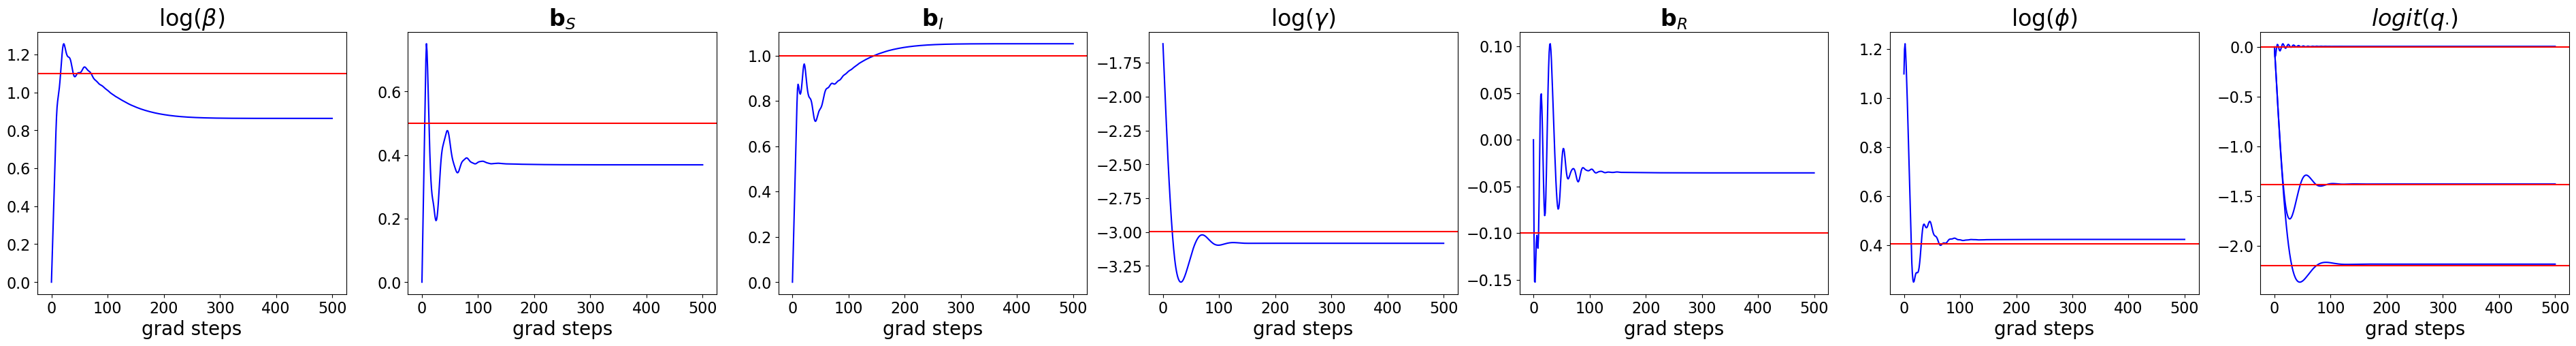

In [221]:
fig, ax = plt.subplots(1, len(learning_parameters), figsize = ((len(learning_parameters)+1)*6, 5))

ylabel_dict = { "log_beta" : "$\\log(\\beta)$", 
		"b_S" : "$\mathbf{b}_{S}$", 
		"b_I": "$\mathbf{b}_{I}$", 
		"log_gamma": "$\\log(\\gamma)$", 
		"b_R": "$\mathbf{b}_{R}$",
		"log_phi":"$\\log(\\phi)$",
		"logit_prob_testing":"$logit(q_{\cdot})$",
		}

counter = -1
for key in learning_parameters.keys():
	
	for i in range(learning_parameters[key]):
		ax[counter+1].set_title(ylabel_dict[key])
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")
		ax[counter+1].set_xlabel("grad steps")

	counter = counter +1

In [222]:
parameters_optimized = {}

for key in parameters.keys():

	if key in parameters_tensor.keys():
		parameters_optimized[key] = parameters_tensor[key][-1,...]

	else:
		parameters_optimized[key] = parameters[key]

Pi, Mu, log_likelihood_wrong = CAL(SIR_misp, parameters_optimized, Y)

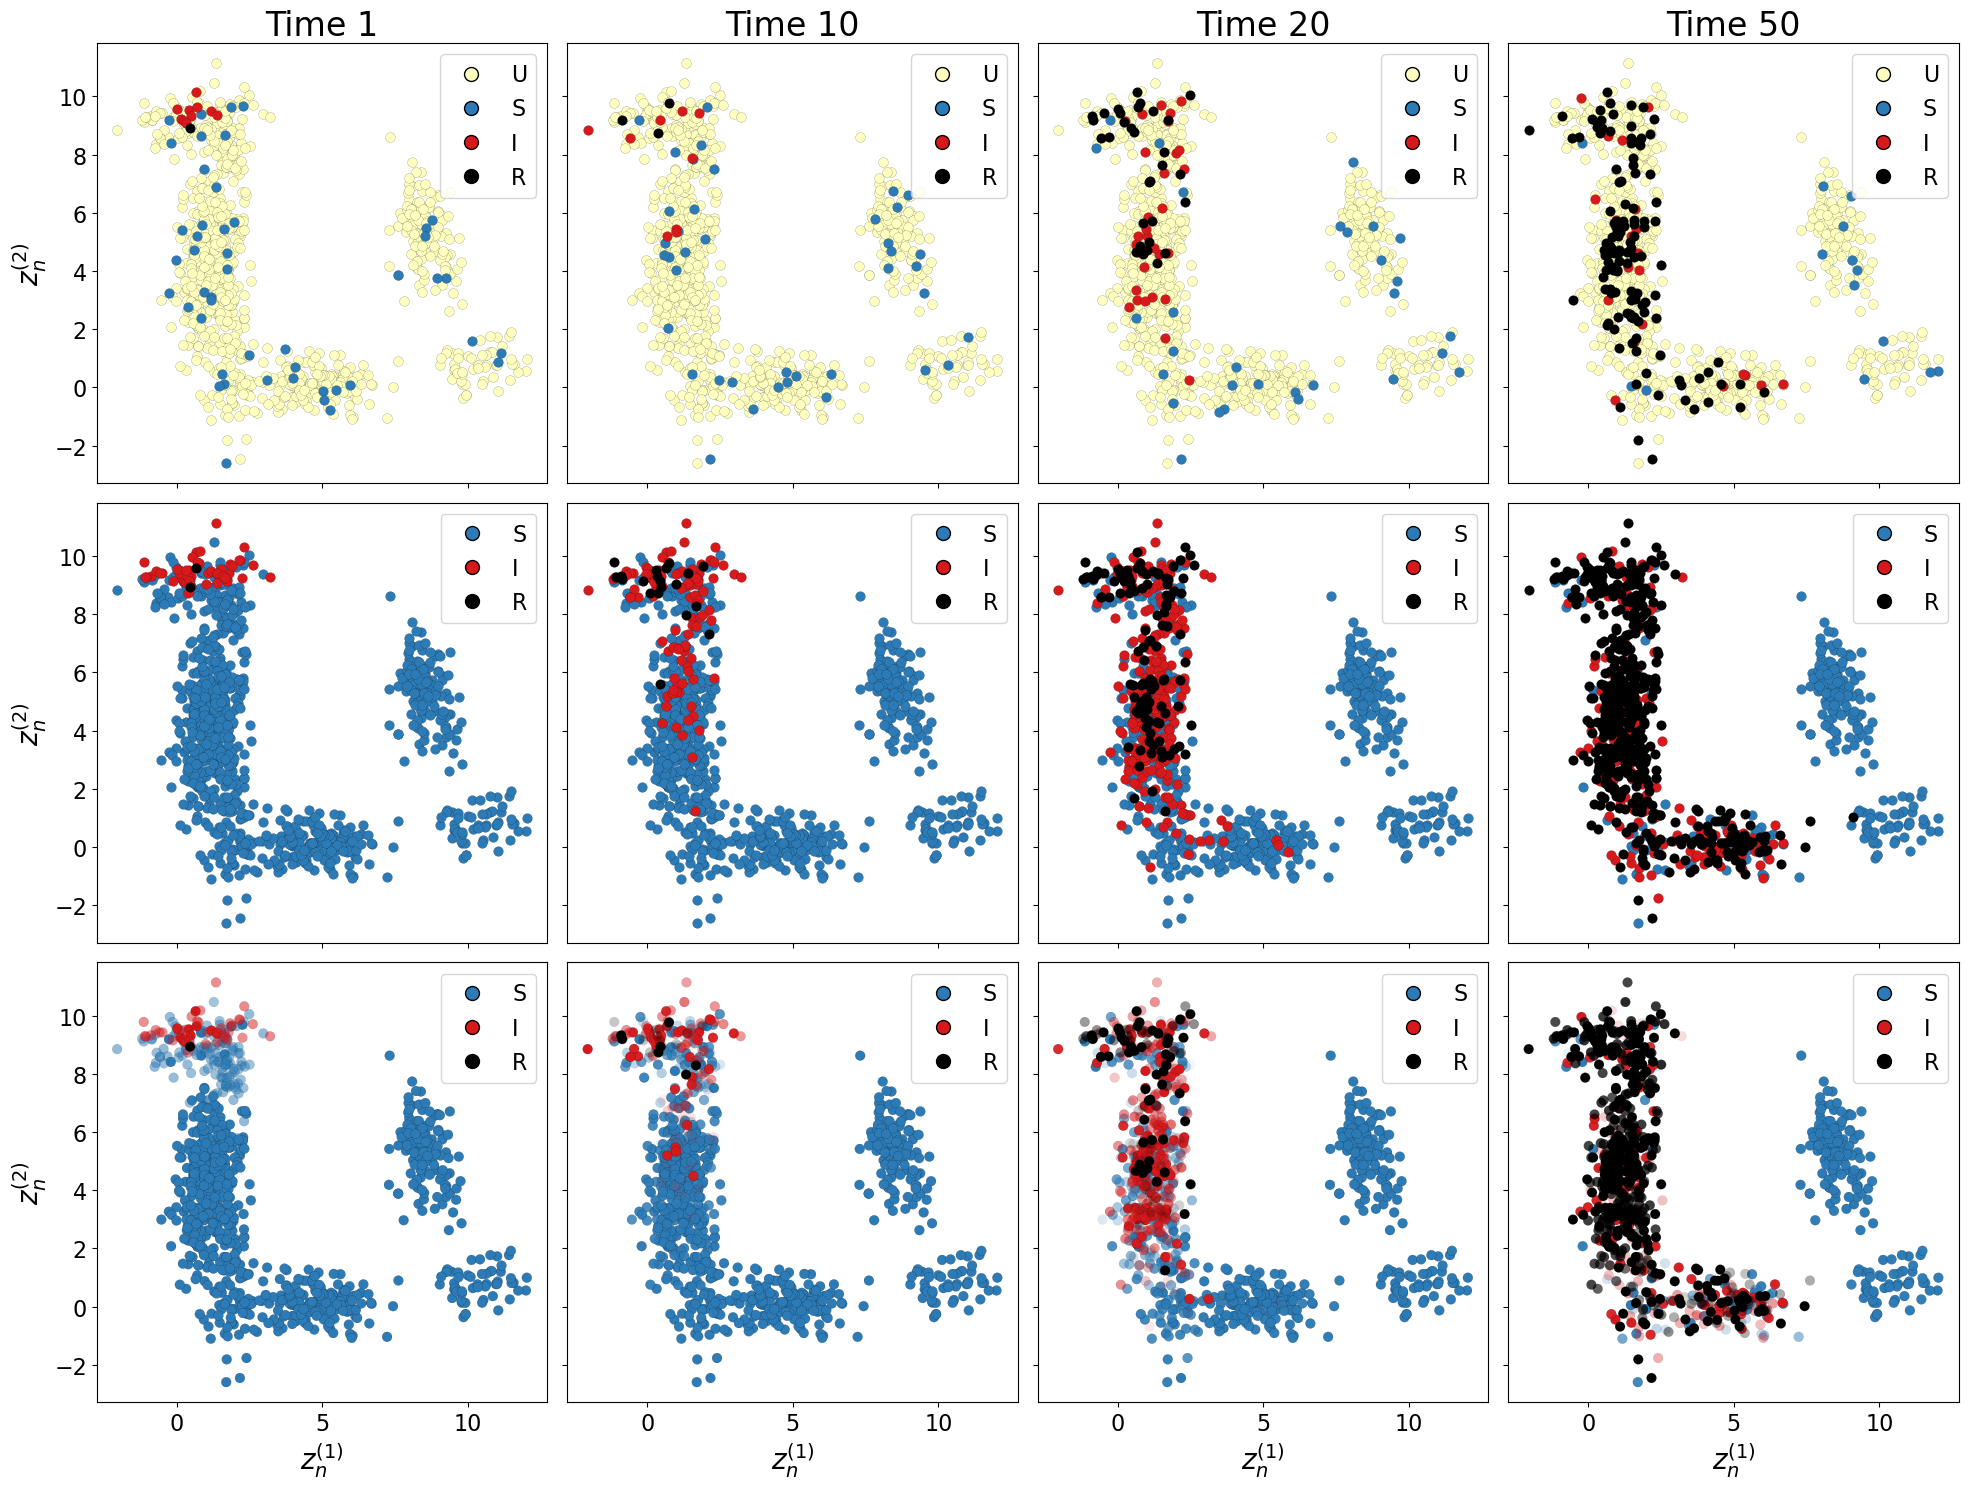

In [228]:
fig, ax = plt.subplots(3, 4, figsize = (20, 15), sharex=True, sharey=True)

time_list = [1, 10, 20, 50]

ax[0, 0].set_ylabel(r"$z_n^{(2)}$")
ax[1, 0].set_ylabel(r"$z_n^{(2)}$")
ax[2, 0].set_ylabel(r"$z_n^{(2)}$")

s_size = 50

# maybe plot color when >0.2

for j in range(4):

	t = time_list[j]
	
	ax[0, j].set_title("Time "+str(t))

	loc_y_unrepor = tf.gather(locations, tf.where(Y[t-1,:,0]==1)[:,0], axis = 0)
	loc_y_suscept = tf.gather(locations, tf.where(Y[t-1,:,1]==1)[:,0], axis = 0)
	loc_y_infecte = tf.gather(locations, tf.where(Y[t-1,:,2]==1)[:,0], axis = 0)
	loc_y_removed = tf.gather(locations, tf.where(Y[t-1,:,3]==1)[:,0], axis = 0)

	ax[0, j].scatter(loc_y_unrepor[:,0], loc_y_unrepor[:,1], color = "#ffffbf", s = s_size, edgecolors='black', linewidths=0.1 )
	ax[0, j].scatter(loc_y_suscept[:,0], loc_y_suscept[:,1], color = "#2c7bb6", s = s_size, edgecolors='black', linewidths=0.1)
	ax[0, j].scatter(loc_y_infecte[:,0], loc_y_infecte[:,1], color = "#d7191c", s = s_size, edgecolors='black', linewidths=0.1)
	ax[0, j].scatter(loc_y_removed[:,0], loc_y_removed[:,1], color = "black",   s = s_size, edgecolors='black', linewidths=0.1)
	
	legend_handles = [
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#ffffbf", markeredgecolor='black', markersize=10, label="U"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#2c7bb6", markeredgecolor='black', markersize=10, label="S"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#d7191c", markeredgecolor='black', markersize=10, label="I"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="black",   markeredgecolor='black', markersize=10, label="R")
	]

	ax[0, j].legend(handles=legend_handles, loc = "upper right")

	infected = tf.where(X[t,:,1]==1)[:,0]

	loc_suscept = tf.gather(locations, tf.where(X[t,:,0]==1)[:,0], axis = 0)
	loc_infecte = tf.gather(locations, tf.where(X[t,:,1]==1)[:,0], axis = 0)
	loc_removed = tf.gather(locations, tf.where(X[t,:,2]==1)[:,0], axis = 0)

	ax[1, j].scatter(loc_suscept[:,0], loc_suscept[:,1], color = "#2c7bb6", s = s_size, edgecolors='black', linewidths=0.1)
	ax[1, j].scatter(loc_infecte[:,0], loc_infecte[:,1], color = "#d7191c", s = s_size, edgecolors='black', linewidths=0.1)
	ax[1, j].scatter(loc_removed[:,0], loc_removed[:,1], color = "black",   s = s_size, edgecolors='black', linewidths=0.1)
	
	legend_handles = [
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#2c7bb6", markeredgecolor='black', markersize=10, label="S"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#d7191c", markeredgecolor='black', markersize=10, label="I"),	
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="black",   markeredgecolor='black', markersize=10, label="R")
	]

	ax[1, j].legend(handles=legend_handles)

	alpha_suscept = tf.gather(Pi[t,:,0], tf.where(X[t,:,0]==1)[:,0], axis = 0)
	alpha_infecte = tf.gather(Pi[t,:,1], tf.where(X[t,:,1]==1)[:,0], axis = 0)
	alpha_removed = tf.gather(Pi[t,:,2], tf.where(X[t,:,2]==1)[:,0], axis = 0)

	# CAL_prediction = tf.one_hot(tf.math.argmax(Pi, axis = -1), 3)
	# loc_suscept_Pi = tf.gather(locations, tf.where(CAL_prediction[t,:,0]==1)[:,0], axis = 0)
	# loc_infecte_Pi = tf.gather(locations, tf.where(CAL_prediction[t,:,1]==1)[:,0], axis = 0)
	# loc_removed_Pi = tf.gather(locations, tf.where(CAL_prediction[t,:,2]==1)[:,0], axis = 0)

	ax[2, j].scatter(loc_suscept[:,0], loc_suscept[:,1], color = "#2c7bb6", alpha = alpha_suscept, s = s_size, edgecolors='black', linewidths=0.1)
	ax[2, j].scatter(loc_infecte[:,0], loc_infecte[:,1], color = "#d7191c", alpha = alpha_infecte, s = s_size, edgecolors='black', linewidths=0.1)
	ax[2, j].scatter(loc_removed[:,0], loc_removed[:,1], color = "black",   alpha = alpha_removed, s = s_size, edgecolors='black', linewidths=0.1)

	# ax[2, j].scatter(loc_suscept_Pi[:,0], loc_suscept_Pi[:,1], color = "#2c7bb6", s = s_size, edgecolors='black', linewidths=0.1)
	# ax[2, j].scatter(loc_infecte_Pi[:,0], loc_infecte_Pi[:,1], color = "#d7191c", s = s_size, edgecolors='black', linewidths=0.1)
	# ax[2, j].scatter(loc_removed_Pi[:,0], loc_removed_Pi[:,1], color = "black",   s = s_size, edgecolors='black', linewidths=0.1)
	

	ax[2, j].set_xlabel(r"$z_n^{(1)}$")

	legend_handles = [
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#2c7bb6", markeredgecolor='black', markersize=10, label="S"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#d7191c", markeredgecolor='black', markersize=10, label="I"),
	plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="black",   markeredgecolor='black', markersize=10, label="R")
	]

	ax[2, j].legend(handles=legend_handles)

plt.tight_layout()
plt.savefig('Figures/misp_filter.png', format='png', dpi=100, bbox_inches='tight')

In [225]:
print("categorical log-likelihood from rand         ", tf.reduce_mean(tf.math.log(tf.reduce_sum(X*X_random_pred, axis = -1))).numpy())
print("categorical log-likelihood from prop         ", tf.reduce_mean(tf.math.log(tf.reduce_sum(X*X_propagate_pred, axis = -1))).numpy())
print("categorical log-likelihood from prop certain ", tf.reduce_mean(tf.math.log(tf.reduce_sum(X*X_propagate_pred_certain, axis = -1))).numpy())
print("categorical log-likelihood from CAL          ", tf.reduce_mean(tf.math.log(tf.reduce_sum(X*Pi, axis = -1))).numpy())

print("accuracy from rand         ", np.sum(X*tf.one_hot(tf.math.argmax(X_random_pred, axis = -1), 3))/np.prod(X.shape[:2]))
print("accuracy from prop         ", np.sum(X*tf.one_hot(tf.math.argmax(X_propagate_pred, axis = -1), 3))/np.prod(X.shape[:2]))
print("accuracy from prop certain ", np.sum(X*tf.one_hot(tf.math.argmax(X_propagate_pred_certain, axis = -1), 3))/np.prod(X.shape[:2]))
print("accuracy from CAL          ", np.sum(X*tf.one_hot(tf.math.argmax(Pi, axis = -1), 3))/np.prod(X.shape[:2]))

categorical log-likelihood from rand          -0.93723583
categorical log-likelihood from prop          -0.81768674
categorical log-likelihood from prop certain  -0.6784715
categorical log-likelihood from CAL           -0.30148247
accuracy from rand          0.5078811881188119
accuracy from prop          0.667910891089109
accuracy from prop certain  0.667910891089109
accuracy from CAL           0.8755148514851485


In [145]:
tf.reduce_mean(tf.cast(tf.reduce_all(X[1,...] == X[2,...], axis = -1), tf.float32))

<tf.Tensor: shape=(), dtype=float32, numpy=0.995>

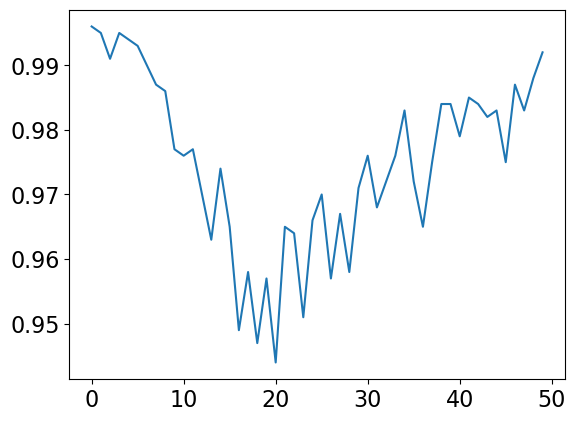

In [154]:
plt.plot([tf.reduce_mean(tf.cast(tf.reduce_all(X[i,...] == X[i+1,...], axis = -1), tf.float32)) for i in range(50)])